In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic2"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import(
    load_excel, 
    load_odin_as_ml_dataset, 
    plot_confusion_matrix, 
    make_ml_dataset, 
    run_binary_regression, 
    transport_modes, 
    trip_motives, 
    province_codes, 
    transport_mode_col, 
    IGNORE_RULES, 
    apply_ignore_rules,
    number_of_sub_trips_col,
    id_col
    )
run_ML = False
%load_ext autoreload
%autoreload 2

Changed to c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation


In [2]:
years = [2019, 2020, 2021, 2022, 2023]
dfs = []
for year in years:
    odin_excel_path = os.path.join(os.getcwd(), "data", "OdiN 2019-2023", f"OdiN {year}", f"ODiN{year}_Databestand.csv")
    if year in [2019, 2020]:
        odin_excel_path = odin_excel_path.replace("Databestand", "Databestand_v2.0")
    df = load_excel(odin_excel_path)
    # df = apply_ignore_rules(df, IGNORE_RULES)   # <<–– new line

    dfs.append(df[df[number_of_sub_trips_col] == 1])  # Filter for single sub-trips

df_all = pd.concat(dfs, ignore_index=True, join="inner")
# Convert 'ActDuur' to numeric, handling errors by coercing NaN to 0
df_all['ActDuur'] = pd.to_numeric(df_all['ActDuur'], errors='coerce').fillna(0)

Loaded file from CSV
Loaded file from CSV
Loaded file from CSV
Loaded file from CSV
Loaded file from CSV


In [ ]:
df_all = apply_ignore_rules(df_all, IGNORE_RULES)  # Apply ignore rules after filtering

Now a classifier that classifies what mode of transport was used

In [ ]:
from codebase import (run_multiclass_classification,
                      distance_col, 
                      origin_col, 
                      province_codes, 
                      level_mapping_suffix, 
                      age_col, 
                      transport_mode_col, 
                      motive_col, 
                      urbanness_col,
                      categorical_cols)


df_multiclass = df_all[df_all[transport_mode_col] != df_all[transport_mode_col].max()]

In [5]:
from codebase import urbanness_col, motive_col

age_range = (0, np.inf)
vehicles_to_include = [1, 7, 8, 9, ]

df_less_vehicles = df_multiclass[df_multiclass[transport_mode_col].isin(vehicles_to_include)]
df_less_vehicles: pd.DataFrame = df_less_vehicles[(df_less_vehicles[age_col] < age_range[1]) & (df_less_vehicles[age_col] > age_range[0])]

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetClassifier


class SktorchNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[64], dtype=torch.float64):
        super(SktorchNN, self).__init__()
        layers = []
        for size in hidden_layers:
            layers.append(nn.Linear(input_dim, size, dtype=dtype))
            layers.append(nn.ReLU())
            input_dim = size
        layers.append(nn.Linear(size, output_dim, dtype=dtype))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

Using device: cuda
Common labels: [0 1 2 3]
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1           nan       0.4724           nan        46.4627
      2           nan       0.4724           nan        47.7845


c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

                      precision    recall  f1-score   support

       Passenger car       0.47      1.00      0.64     70523
    Electric bicycle       0.00      0.00      0.00     10541
Non-electric bicycle       0.00      0.00      0.00     33669
             On foot       0.00      0.00      0.00     34802

            accuracy                           0.47    149535
           macro avg       0.12      0.25      0.16    149535
        weighted avg       0.22      0.47      0.30    149535



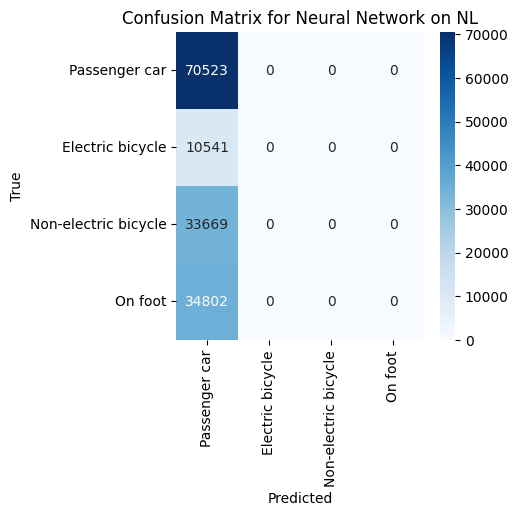

In [9]:
from codebase import run_multiclass_classification
from skorch.callbacks import Checkpoint

save_path = "neural_net_checkpoints"
os.makedirs(save_path, exist_ok=True)
checkpoint = Checkpoint(monitor='valid_loss_best', f_params='best_model.pt')
early_stopping = Checkpoint(monitor='valid_loss_best', f_patience=2, f_params='best_model.pt')
device='cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

lr = 0.001
input_dim=210
output_dim=len(vehicles_to_include)
hidden_layers=[500, 200, 100]
max_epochs=5

net = NeuralNetClassifier(
    SktorchNN(input_dim=input_dim, output_dim=output_dim, hidden_layers=hidden_layers),
    max_epochs=max_epochs,
    lr=lr,
    batch_size=32,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    verbose=1,
    device=device,
    callbacks=[checkpoint, early_stopping],
)
pipeline_less, (X_train_less, _, _, _), accuracy = run_multiclass_classification(
        df_less_vehicles,
        test_size=0.2,
        model=net,
        categorical_features=categorical_cols,
        plot=True,
        savename=f"graphics/classification_results/multiclass/neural_net/less_vehicles",
        plot_title=f"Confusion Matrix for Neural Network on NL",
        y_translation={val: order for order, val in enumerate(vehicles_to_include)},
    )